# **Transfer Learning Models Usage for Melanoma Detection**

The aim of this notebook is to offer an analysis of the usage of two main pretrained CNN models adapted to our new problem: Melanoma image classification.

### **Author:** Antonio Cantillo Molina

---

## **Libraries**

In [ ]:
# Install and upgrade fastai and related libraries
!pip install -U "fastai==2.7.15" "fastcore==1.5.29" "fastprogress==1.0.3" "fastdownload==0.0.7"

# Import necessary libraries
import os
from google.colab import files, drive
from google.colab import drive
from fastai.vision.all import *
import fastcore
from pathlib import Path
import timm
import time
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
!pip install dill
import dill

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 

## **Auxiliar Functions**

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    """
    Plots the training and validation metrics recorded during the learning process.

    This function extends the fastai `Recorder` class to visualize various metrics
    (e.g., losses, accuracy, F1-score) over epochs.
    Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

    Args:
        self (Recorder): The Recorder object containing the metric history.
        nrows (int, optional): Number of rows for the subplot grid. Defaults to None.
        ncols (int, optional): Number of columns for the subplot grid. Defaults to None.
        figsize (tuple, optional): Figure size (width, height) in inches. Defaults to None.
        **kwargs: Additional keyword arguments passed to `fastai.plt.subplots`.

    Returns:
        None: Displays the plot directly.
    """
    # Stack the recorded metric values into a NumPy array
    metrics = np.stack(self.values)
    # Get the names of the metrics (excluding 'epoch' and 'time')
    names = self.metric_names[1:-1]
    n = len(names) - 1 # Number of metrics to plot (excluding 'time' and 'epoch', and 'valid_loss' for the first plot)

    # Determine the number of rows and columns for the subplot grid
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))

    # Set the figure size, default if not provided
    figsize = figsize or (ncols * 6, nrows * 4)
    # Create the subplot grid
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    # Flatten the axes array and set unused axes to off if n < total subplots
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

    # Iterate through each metric and plot it
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)): # [axs[0]] + axs ensures loss is plotted on the first ax
        # Plot training and validation metrics. First plot shows train loss (blue), others show valid loss (orange).
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        # Set the title for each subplot
        ax.set_title(name if i > 1 else 'losses') # Title 'losses' for the first plot, otherwise the metric name
        # Display legend
        ax.legend(loc='best')
    plt.show() # Display the plot

In [ ]:
def melanoma_auc_recall(learn, dl, class_name='melanoma'):
    """
    Calculates and plots AUC and Recall for a specific class using fastai tensors.

    This function retrieves predictions and true labels from a fastai Learner object
    for a given DataLoader and then computes the Area Under the Receiver Operating
    Characteristic Curve (AUC) and Recall for a specified class. It also generates
    and displays an ROC curve plot.

    Args:
        learn (fastai.learner.Learner): The trained fastai Learner object.
        dl (fastai.data.core.DataLoader): The DataLoader (e.g., dls.valid, dls.train)
                                          from which to get predictions and targets.
        class_name (str, optional): The name of the class for which to calculate
                                    AUC and Recall. Defaults to 'melanoma'.

    Returns:
        tuple: A tuple containing the calculated AUC and Recall scores for the
               specified class. Returns (None, None) if the class name is not found.
    """
    if class_name not in learn.dls.vocab:
        print(f"⚠️ Warning: The class '{class_name}' does not exist in the vocabulary.")
        return None, None

    # 1. Get the index of the specified class and model predictions
    idx = learn.dls.vocab.o2i[class_name]
    preds, targs = learn.get_preds(dl=dl)

    # 2. Filter predictions and targets for the specified class (Fastai style tensors)
    y_score = preds[:, idx]       # Probabilities for the positive class
    y_true  = (targs == idx)      # Binary target (True/False) indicating presence of the class

    # 3. Calculate metrics using sklearn (handles implicitly converted PyTorch tensors)
    auc = roc_auc_score(y_true, y_score)
    rec = recall_score(y_true, preds.argmax(dim=1) == idx)

    print(f"\n📊 Metrics for '{class_name}':")
    print(f"   • ROC-AUC: {auc:.4f}")
    print(f"   • Recall:  {rec:.4f}")

    # 4. Plot the Receiver Operating Characteristic (ROC) Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0,1], [0,1], 'k--') # Diagonal dashed line for reference
    plt.title(f"ROC: {class_name} vs Rest")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    return auc, rec

In [ ]:
def show_results(dls, learner, mode, melanoma_class='melanoma'):
    """
    Displays the Confusion Matrix and calls the `melanoma_auc_recall` function
    for a specified mode (Train, Validation, or Test).

    Args:
        dls (fastai.data.core.DataLoaders): The fastai DataLoaders object containing
                                             training, validation, and optionally test DataLoaders.
        learner (fastai.learner.Learner): The trained fastai Learner object.
        mode (str): The mode for which to show results. Must be 'Train', 'Validation', or 'Test'.
        melanoma_class (str, optional): The name of the class to focus on for AUC and Recall.
                                        Defaults to 'melanoma'.

    Raises:
        ValueError: If an unsupported mode is provided.
    """
    print(f"\n{'='*20} Evaluating: {mode} {'='*20}")

    # 1. DataLoader Selector
    if mode == 'Validation': dl = dls.valid
    elif mode == 'Train':    dl = dls.train
    elif mode == 'Test':
      # For the 'Test' mode, create a test DataLoader from image files
      test_files = [fn for fn in sorted(test_path.glob('**/*')) if fn.is_file()]
      dl = learner.dls.test_dl(test_files,with_labels=True, device='cuda') # Test set also normalized the same way
    else: raise ValueError("Mode must be 'Train', 'Validation' or 'Test'")

    # 2. Confusion Matrix and Global Accuracy
    interp = ClassificationInterpretation.from_learner(learner, dl=dl)
    interp.plot_confusion_matrix(figsize=(6, 6), title=f'Confusion Matrix ({mode})')
    plt.show()

    cm = interp.confusion_matrix()
    acc = np.trace(cm) / np.sum(cm) * 100
    print(f"✅ Global Accuracy: {acc:.2f}%")

    # 3. Call to the separate metrics function
    melanoma_auc_recall(learner, dl, class_name=melanoma_class)

## **Dataset Preparing**

### **Download**

To download the file and ensure no time is wasted, we decided to use Google Gemini to build a pipeline for downloading the dataset:

**You are an expert in Kaggle, datasets, deep learning and python. I need a pipeline to be able to download a dataset from Kaggle. You need to include flags to avoid downloading the dataset every time the cell is executed, as well as oher security flags. Manage resources in a way the access to the dataset is fast.**

---

<br>

After a few minor changes, we obtained an excellent pipeline to obtain the dataset without the need to download every time the cell is executed. This is only necessary when the environment is changed.

The authentication with Kaggle is carried out through the upload of a JSON file generated from the person's personal account. Once the file is uploaded, the zip containing the dataset will be downloaded, then unzipped and deleted.

Everything is managed in dymanic memory, so it is necessary to activate **High RAM Capacity** when selecting the environment.

In [ ]:
# --- 1. KAGGLE API CONFIGURATION ---
kaggle_json_path = os.path.expanduser("~/.config/kaggle/kaggle.json")
token_setup_successful = False

# Check if kaggle.json already exists
if not os.path.exists(kaggle_json_path):
    print("⬇️ Token not found. Upload your kaggle.json file ⬇️")
    uploaded = files.upload() # files.upload() returns a dict of uploaded files

    if 'kaggle.json' in uploaded:
        # Create the hidden folder if it doesn't exist
        !mkdir -p ~/.config/kaggle
        # Move the json file into it
        !mv kaggle.json ~/.config/kaggle/ # Use mv to avoid leaving a copy in /content
        # Set secure permissions (read/write only for user)
        !chmod 600 ~/.config/kaggle/kaggle.json
        print("✅ Configuration complete: File moved to ~/.config/kaggle/")
        token_setup_successful = True

        # Install kaggle library and check its version
        !pip install kaggle --quiet
        !kaggle --version
        from kaggle.api.kaggle_api_extended import KaggleApi
    else:
        print("❌ kaggle.json file not uploaded. Make sure to upload it to continue.")
else:
    print("✅ kaggle.json already exists in ~/.config/kaggle/. Skipping upload.")
    token_setup_successful = True

# Proceed with authentication and download only if the token was set up correctly
if token_setup_successful:
    try:
        # Initialize the API (this must always be done to ensure the API is authenticated)
        # The API will automatically look for the kaggle.json file in ~/.config/kaggle/
        api = KaggleApi()
        api.authenticate()
        print("✅ Kaggle API authentication successful.")

        # --- 2. DATASET DOWNLOAD ---
        dataset_path = '/content/dataset'

        # Check if the dataset is already downloaded and unzipped
        # Check if the folder exists and if it contains files
        if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
            print("⏳ Downloading dataset to /content/dataset...")
            api.dataset_download_files(
                'wanderdust/skin-lesion-analysis-toward-melanoma-detection',
                path=dataset_path,
                unzip=True,
                quiet=False
            )
            print("✅ Download complete!")

            # Delete the downloaded zip file to save space
            print("🧹 Cleaning up zip files...")
            for file in os.listdir(dataset_path):
                if file.endswith(".zip"):
                    os.remove(os.path.join(dataset_path, file))
            print("✅ Zip file deleted successfully.")
        else:
            print("✅ Dataset already downloaded and unzipped in /content/dataset/. Skipping download.")
    except Exception as e:
        print(f"❌ Error during authentication or dataset download: {e}")
else:
    print("⚠️ Cannot proceed with authentication or dataset download without a valid kaggle.json file.")

⬇️ Token not found. Upload your kaggle.json file ⬇️


Saving kaggle.json to kaggle.json
✅ Configuration complete: File moved to ~/.config/kaggle/
Kaggle API 1.7.4.5
✅ Kaggle API authentication successful.
⏳ Downloading dataset to /content/dataset...
Dataset URL: https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection


100%|██████████| 11.3G/11.3G [00:34<00:00, 356MB/s]



✅ Download complete!
🧹 Cleaning up zip files...
✅ Zip file deleted successfully.


## **Transfer Learning Models**

In order to solve our Melanoma Image Classification problem, another approach that can be taken is to take pretrained models and use their knowledge to our advantage.

There are several models out there, but we are going to focus on only two of them that can be useful for our specific problem: EfficientNet Network Models and Inception-ResNet-v2.

### **EfficientNet Network Models**

The main objective of any neural network is to combine increased accuracy with efficiency, taking into account the number of available resources. Traditionally, efficiency and accuracy gains are achieved by modifying the depth, width, and resolution of CNNs. Although increasing the width, depth, or resolution enhances the network’s expressive capacity, how can we **efficiently** improve its accuracy?

The adequate approach is **model scaling**. This is a technique that involves avoiding changes to the layers that make up the network itself and instead considering expanding the network’s depth, width, and/or resolution. These three properties are highly interdependent, which is why traditionally only one of them has been expanded. This is the main problem:

- Increasing depth (adding more layers to the network) guarantees a greater capacity to learn complex patterns, but it makes training more difficult due to issues such as the so-called "vanishing gradient".

- Increasing the width allows us to detect fine details and makes training easier, but in return we lose the ability to recognize higher level features.

- Increasing the input resolution allows us to detect fine features, but only up to a point, since for large models it no longer translates into higher precision or accuracy.

Since each of the previously mentioned properties present advantages and disadvantages, we could consider combining the expansion of more than one of these aspects while scaling a model. This idea is called **Compound Scaling** and it is the fundamental core on which EfficientNetB0 and all the networks in its family are based. The problem presents as follows:

Most networks have a structure based on the composition of layers. Notably, they tend to use repetitively certain layers in different stages, we can represent a CNN as $\mathcal{N}$ such that: <br><br>

$$\mathcal{N} = \bigodot_{i=1...s} \mathcal{F}_i^{L_i} (X_{\langle H_i, W_i, C_i \rangle})$$
<br>
where $\bigodot$ represents the composition operation, $\mathcal{F}_i^{L_i}$ denotes a layer $F_i$ repeated $L_i$ times in stage $i$ and $(X_{\langle H_i, W_i, C_i \rangle})$ is the input tensor $X$ with shape ${\langle H_i, W_i, C_i \rangle}$ (where $H_i$ is height, $W_i$ width and $C_i$ channels).

The main objective is to maximize accuracy in a model by increasing depth, width and resolution compoundly. That is:<br><br>

\begin{aligned}
& \max_{d,w,r} & & Accuracy(\mathcal{N}(d, w, r)) \\
& s.t. & & \mathcal{N}(d, w, r) = \bigodot_{i=1...s} \hat{\mathcal{F}}_i^{d \cdot \hat{L}_i} (X_{\langle r \cdot \hat{H}_i, r \cdot \hat{W}_i, w \cdot \hat{C}_i \rangle}) \\
& & & Memory(\mathcal{N}) \leq target\_memory \\
& & & FLOPS(\mathcal{N}) \leq target\_flops
\end{aligned} $\tag{1}$

In order to achieve this, a scaling method is proposed. EfficientNet Network family perform **Compound Scaling** using a scaling method that consists of a compound scaling component ($\phi$) and three constant parameters $\alpha$, $\beta$, and $\gamma$. These last three parameters ($\alpha$, $\beta$, and $\gamma$) are found by performing a small grid search and they determine the amount of resources allocated to depth ($d$), width ($w$), and resolution ($r$), respectively. Now, the scaling component $\phi$ is used to uniformly scale network's width, depth and resolution in the following way:<br><br>

$$d = \alpha^{\phi}, \quad w = \beta^{\phi}, \quad r = \gamma^{\phi} \tag{2}$$
<br>
Furthermore, this compound scaling method (used in EfficientNet Networks) establishes that $\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$, ($\alpha \geq 1, \beta \geq 1, \gamma \geq 1$). **Why is that?** In a network, most operations (**FLOPS**) are concentrated in the convolutional layers. Therefore, it is clear to see that increasing the network's width and resolution of the images we work with increases the computational cost quadratically, respectively (while depth increases it linearly). Hence, approximately, the increase in number of FLOPS scales by $(\alpha \cdot \beta^2 \cdot \gamma^2)^{\phi}$.

To guarantee responsible usage of resources, it is set that $\alpha \cdot \beta^2 \cdot \gamma^2$ is approximately $2$ to ensure that the increase in resources used is at most $2^{\phi}$ (for each scaling factor $\phi$ we consider).

This method for performing Compound Scaling is **not** exclusive to the EfficientNet networks family. However, the effectiveness of the scaling relies on having a high-quality baseline network. EfficientNet networks use EfficientNetB0 as a baseline, which was not designed manually but discovered through Neural Architecture Search (NAS) using Reinforcement Learning techniques.

In order to do that, the authors followed the MnasNet methodology (Tan et al., 2019). In this process, a neural network "controller" samples different architectural possibilities (varying kernel sizes, layers, etc...) to create candidate models. Each candidate is trained and evaluated to calculate a **reward**. This **reward** is a weighted score that considers both the model's accuracy and its computational efficiency (FLOPS):<br><br>

$$R(m) = ACC(m) \times \left[ \frac{FLOPS(m)}{T} \right]^w$$<br>

where $m$ is the sampled candidate model, $T$ is the target FLOPS and $w$ is:<br><br>

$$
\begin{equation}
w =
\begin{cases}
\alpha', & \text{if } FLOPS(m) \leq T \\
\beta', & \text{otherwise}
\end{cases}
\end{equation}
$$<br>

where $\alpha'$ and $\beta'$ are application-specific constants.

By maximizing this reward function that identifies Pareto-optimal solutions over time and updating the controller's parameters by using Proximal Policy Optimization (PPO), the controller "learns" to automatically design a network that achieves the best possible trade-off between performance and resource usage.

(The controller aims to identify Pareto-optimal solutions, which represent the set of architectures where accuracy cannot be further improved without increasing computational cost. By exploring this Pareto frontier, the search process ensures that EfficientNetB0 is not just accurate, but the most efficient model possible for its size).

Furthermore, the fundamental building block of the EfficientNetB0 architecture is the **MBConv** (Mobile Inverted Bottleneck Convolution) block. This structure is composed of three primary stages:
- An initial $1 \times 1$ expansion convolution that increases the number of input channels.
- A depthwise separable convolution used for spatial feature extraction.
- A final $1 \times 1$ convolution that reduces the number of channels back to the original or a targeted dimensionality (Bottleneck).

This specific sequence (expanding the dimensionality first and subsequently compressing it) is what defines the Inverted Bottleneck concept. Furthermore, EfficientNetB0 integrates a Squeeze-and-Excitation (SE) optimization. This mechanism operates at a channel-wise level to recalibrate feature maps: it dynamically assigns higher weights to the most informative channels while suppressing less relevant ones, significantly enhancing the network's representational power.

Additionally, it uses a different activation fuction from ReLU: Swish. This activation function is defined by:

$$f(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}$$

Unlike ReLU, the Swish activation function is smooth and non-monotonic, which prevents gradient vanishing and allows for better optimization in deeper architectures.

Now, as stated, EfficientNetB0 represents the base network for its family and compound scaling method is applied in it as follows:

- We initially set the scaling component to $\phi$ = 1 and try to find $\alpha$, $\beta$, and $\gamma$ (via grid search based on $(1)$ and $(2)$) while satisfying the constraint ($\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$).

- Next, we adjust $\alpha$, $\beta$, and $\gamma$ and scale up the network by  using different values of $\phi$. Scaling for different values of $\phi$ results in obtaining the rest of the EfficientNet family networks (which are EfficientNetB0–B7).

Consequently, we see that EfficientNetB0 is the base network, and the rest of the family’s networks are obtained by applying different levels of compound scaling over it.

#### **Main references**

- Tan, M., & Le, Q. (2019). EfficientNet: Rethinking model scaling for convolutional neural networks. Proceedings of the 36th International Conference on Machine Learning (ICML), 6105-6114.

- Tan, M., Chen, B., Pang, R., Vasudevan, V., Sandler, M., Howard, A., & Le, Q. V. (2019). Mnasnet: Platform-aware neural architecture search for mobile. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2820-2828.

- Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. CVPR.

- Hu, J., Shen, L., & Sun, G. (2018). Squeeze-and-Excitation Networks. CVPR.

- Ramachandran, P., Zoph, B., & Le, Q. V. (2017). Searching for activation functions. arXiv.
---
<br>

#### **Why is this model being considered for this problem?**

Melanomas are distinguished by morphological and physical appearance features such as pigmentation patterns, discoloration... Using a network from EfficientNet Family ensures increasing accuracy while scaling both network's depth and width, but also and more importantly input's resolution, which happens to be crucial in order to detect fine-grained features from the skin images from the dataset.

Having higher resolution inputs grants us with the ability of making sure that subtle details are being captured and learnt from by the network model. Since increasing resolution only can present a problem (as previously mentioned), using a network that implements compound scaling is a great solution: EfficientNet.

We will be using EfficientNetB4 as a starting point since resolution could be too low if we used lower versions and because it presents the best trade-off between resolution and computational cost. The ideal network would be EfficientNetB7, since it represents the higher resolution and therefore, the best theoretical accuracy but it may exceed the available computational resources or lead to memory constraints.


### **Creation of the Datablock for first model**

In [ ]:
# List files and directories in the current working directory
!ls -lha
# List files and directories within the downloaded dataset path
!ls /content/dataset/skin-lesions/

total 24K
drwxr-xr-x 1 root root 4.0K Jan  4 09:41 .
drwxr-xr-x 1 root root 4.0K Jan  4 09:19 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Jan  4 09:41 dataset
drwxr-xr-x 4 root root 4.0K Jan  4 09:43 models
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
test  train  valid


In [ ]:
# Define the base path for the dataset
path = Path("/content/dataset/skin-lesions")
# Define paths for training, validation, and test sets
train_path = path/'train'
valid_path = path/'valid'
test_path  = path/'test'

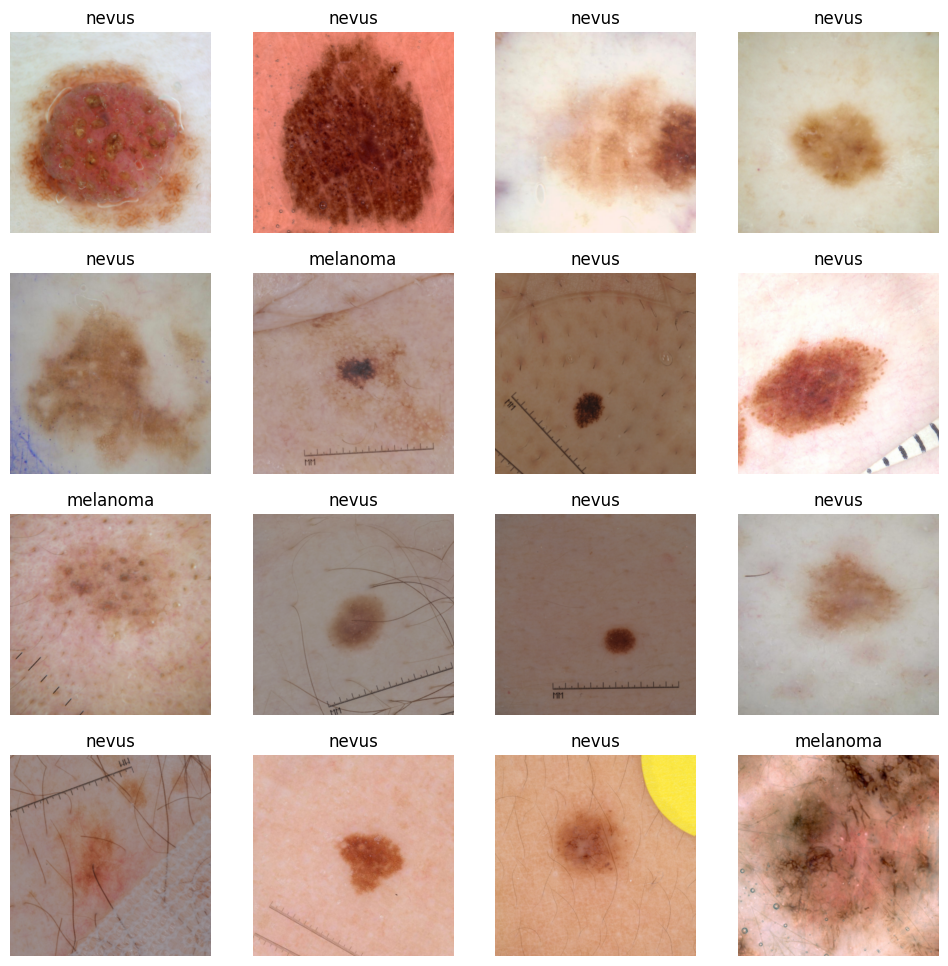

In [ ]:
# Create a DataBlock for image classification
dtblk1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define input (Image) and target (Category) blocks
    get_items=get_image_files,          # Function to get all image files
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), # Split data based on 'train' and 'valid' folders
    get_y=parent_label,                 # Function to get labels from parent folder names
    item_tfms=Resize(460),              # Apply resizing to 460x460 for individual items
    batch_tfms=[                        # Apply batch transformations (augmentation and normalization)
        *aug_transforms(size=384,            # Resizing to 384x384
                        mult=0.5,
                        do_flip=True,        # Allows to flip the images
                        flip_vert=True,      # Allows to flip the images
                        max_rotate=90.0,     # Up to 90 degrees rotation
                        max_zoom=0.5,        # Max Zoom value
                        max_lighting=0.1,    # Max Lighting transformations value
                        max_warp=0.0         # No warping
                        ),
        Normalize.from_stats(*imagenet_stats) # Normalize using ImageNet statistics
    ]
)

# Create DataLoaders from the DataBlock and the specified path, with a batch size of 16
dls1=dtblk1.dataloaders(path,bs=16)

# Display a batch of images with their labels
dls1.show_batch(max_n=24)

#### **Pipeline**

In order to adapt **EfficientNetB4**, we should define a custom head. Leveraging fastai functionalities, the usage of **vision_learner** introduces an automatic custom head that adapts the network to our new classification problem. (Number of classes: $3$).

Adam as Optimizer and accuracy and F1 Score as metrics will be considered for training. Instead of using the function **fine_tune**, we will manually freeze and unfreeze the network while training in order to be able to manage learning rates more accurately. The head will be trained during 5 epochs and the whole network during 12, both following the one cycle policy using **fit_one_cycle**.

First, we started using CrossEntropyLossFlat as our loss function, alongside Adam as an optimizer. However, the results achieved were not fulfilling and by observing the graphics it was clear the presence of overfitting. Furthermore, two of the three classes proved difficult for the model to predict. That led us to analyze the dataset and find out that there was huge imbalance between the classes.

Therefore, weights for each of the classes were computed and loss function was changed to LabelSmoothingCrossEntropy to allow flexibility during training. To attack the overfitting problem, data augmentation was introduced in our batches.This led to better results.

After some tuning and adding additional regularization techniques as Dropout and Weight decay, we obtain the following results:

First, we check the imbalance between classes:

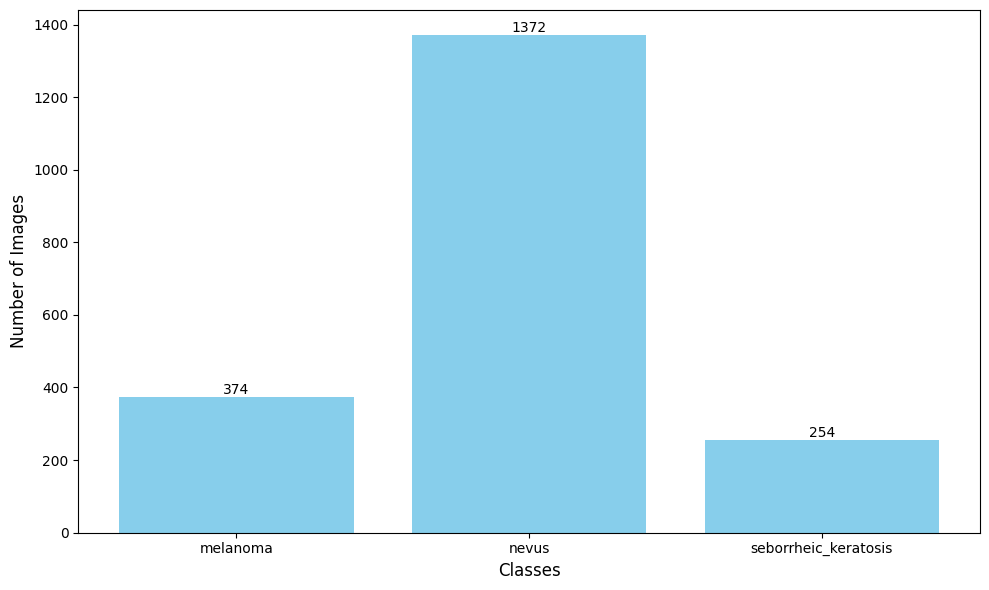

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Obtain the targets
y_train = [dls1.vocab.o2i[parent_label(o)] for o in dls1.train_ds.items]

# Count ocurrences
counts = Counter(y_train)

values = [counts[i] for i in range(len(dls1.vocab))]

# Visualization of results:

plt.figure(figsize=(10, 6))
bars = plt.bar(dls1.vocab, values, color='skyblue')

plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()

Therefore, we use weights for each class in order to stabilize and help the training. After some tuning, the final hyperparameters are:

In [ ]:
# Calculate weights for each class:
from collections import Counter

total = sum(values)
n_classes = len(values)

# Formula: weight = Total / (n_classes * n_examples_per_class)
weights = [total / (n_classes * c) for c in values]
weights_tensor = torch.tensor(weights, dtype=torch.float32).cuda()

#  Create a fastai Vision Learner object
learn1 = vision_learner(dls1,
                        efficientnet_b4,
                        loss_func=LabelSmoothingCrossEntropyFlat(weight=weights_tensor),
                        metrics=[accuracy, F1Score(average='macro')],
                        opt_func=Adam,
                        pretrained=True,
                        ps=0.2)

# Display a summary of the model architecture and trainable parameters
learn1.summary()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential (Input shape: 16 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 48 x 192 x 192 
Conv2d                                    1296       False     
BatchNorm2d                               96         True      
SiLU                                                           
Conv2d                                    432        False     
BatchNorm2d                               96         True      
SiLU                                                           
____________________________________________________________________________
                     16 x 48 x 1 x 1     
AdaptiveAvgPool2d                                              
____________________________________________________________________________
                     16 x 12 x 1 x 1     
Conv2d                                    588        False     
____________________________________________________________________________
                     1

#### **Training**

In [ ]:
# Freeze the model
learn1.freeze()
learn1.summary()

Sequential (Input shape: 16 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 48 x 192 x 192 
Conv2d                                    1296       False     
BatchNorm2d                               96         True      
SiLU                                                           
Conv2d                                    432        False     
BatchNorm2d                               96         True      
SiLU                                                           
____________________________________________________________________________
                     16 x 48 x 1 x 1     
AdaptiveAvgPool2d                                              
____________________________________________________________________________
                     16 x 12 x 1 x 1     
Conv2d                                    588        False     
____________________________________________________________________________
                     1

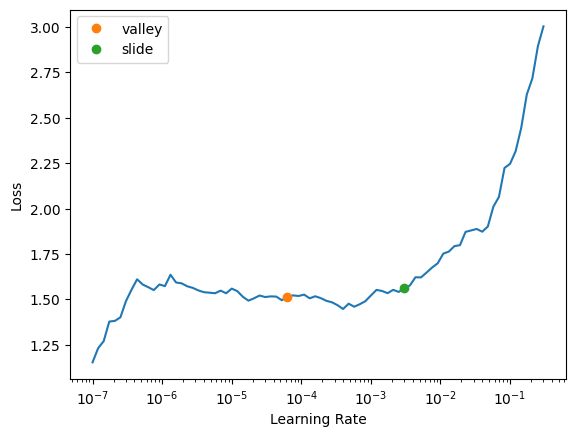

In [ ]:
# Search for valley value to use as learning rate:
lr=learn1.lr_find(suggest_funcs=(valley, slide))

In [ ]:
# Record the start time of training
start=time.time()
# Train ONLY the head:
learn1.fit_one_cycle(5, lr_max=lr[0])
# Record the end time of training
end = time.time()

head_time=end-start

In [ ]:
# Unfreeze the model in order to be able to train the whole network:
learn1.unfreeze()
learn1.summary()

Sequential (Input shape: 16 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 48 x 192 x 192 
Conv2d                                    1296       True      
BatchNorm2d                               96         True      
SiLU                                                           
Conv2d                                    432        True      
BatchNorm2d                               96         True      
SiLU                                                           
____________________________________________________________________________
                     16 x 48 x 1 x 1     
AdaptiveAvgPool2d                                              
____________________________________________________________________________
                     16 x 12 x 1 x 1     
Conv2d                                    588        True      
____________________________________________________________________________
                     1

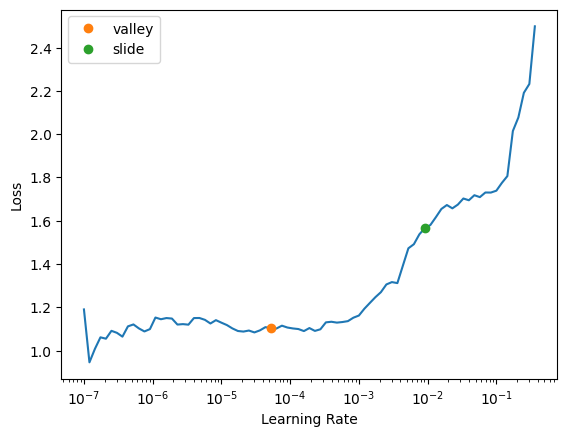

In [ ]:
# Search for valley value to use as learning rate:
lr=learn1.lr_find(suggest_funcs=(valley, slide))

Total training time: 1401.46 seconds


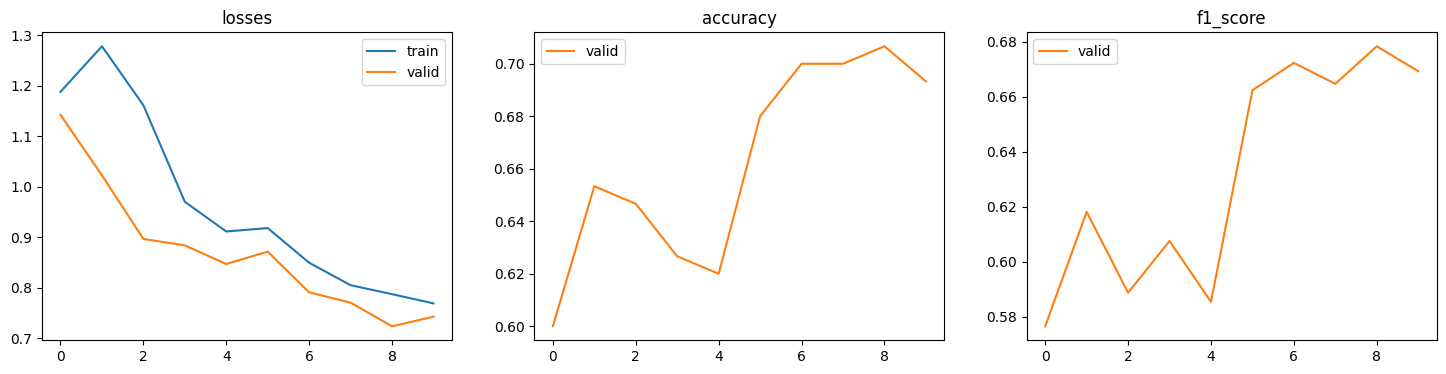

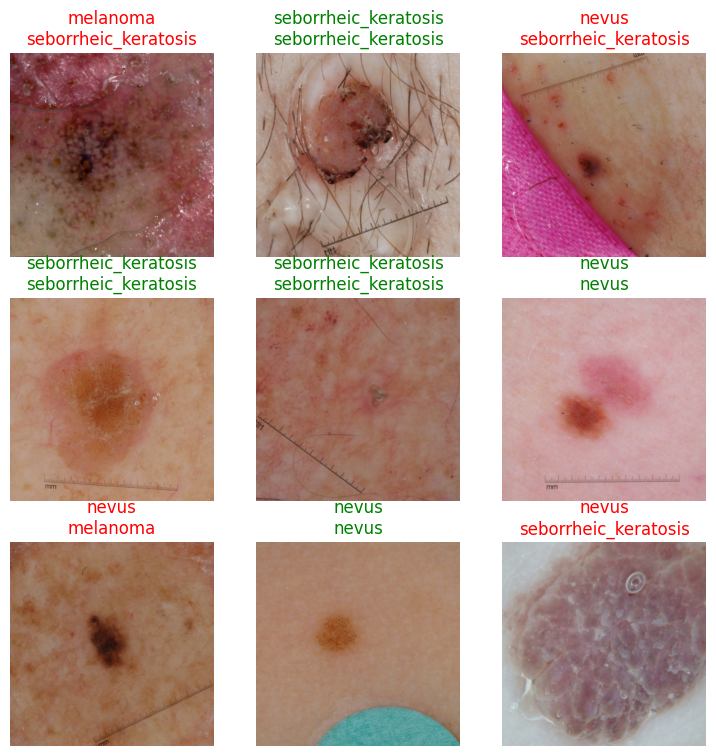

In [ ]:
# Record the start time of training
start=time.time()
# Fine-tuning model:
learn1.fit_one_cycle(10, lr_max=slice(1e-5, 1e-3), wd=0.1, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

# Record the end time of training
end = time.time()

whole_network_time=end-start

# Print the total training time
print(f"Total training time: {whole_network_time + head_time:.2f} seconds")
# Plot the training and validation metrics over epochs
learn1.recorder.plot_metrics()
# Show results (implicitly calls show_results with default 'Validation' mode if not specified, or a quick visual check)
learn1.show_results()


==================== Evaluating: Train ====================


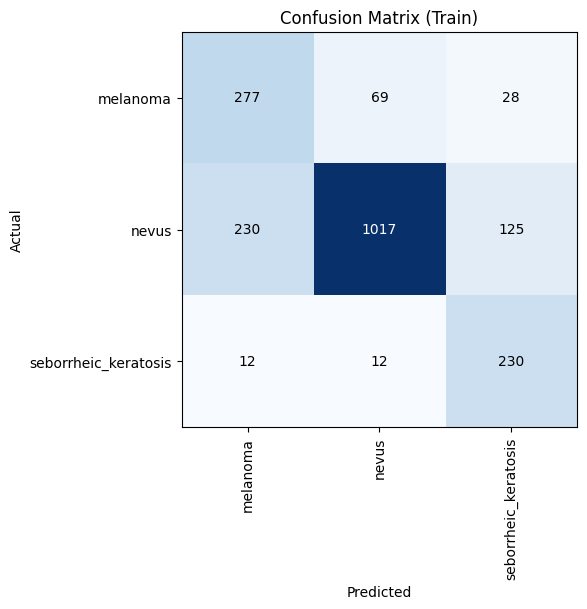

✅ Global Accuracy: 73.90%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8721
   • Recall:  0.7353


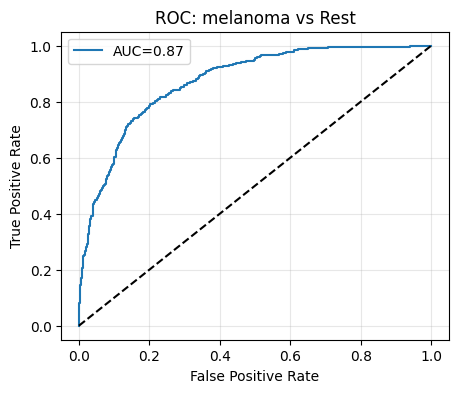

In [ ]:
show_results(dls1, learn1, 'Train', melanoma_class='melanoma')

#### **Validation**


==================== Evaluating: Validation ====================


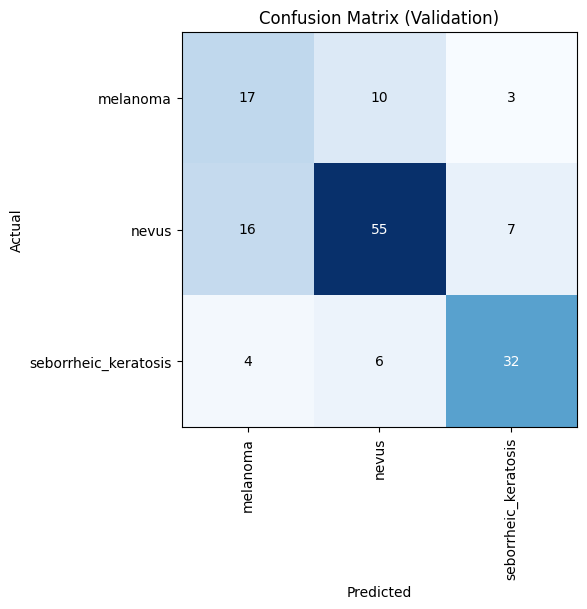

✅ Global Accuracy: 69.33%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8022
   • Recall:  0.5667


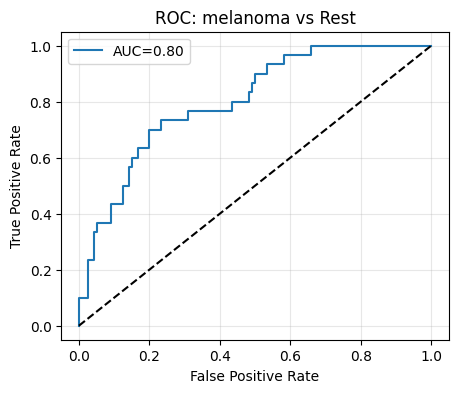

In [ ]:
show_results(dls1, learn1, 'Validation', melanoma_class='melanoma')

#### **Test**


==================== Evaluating: Test ====================


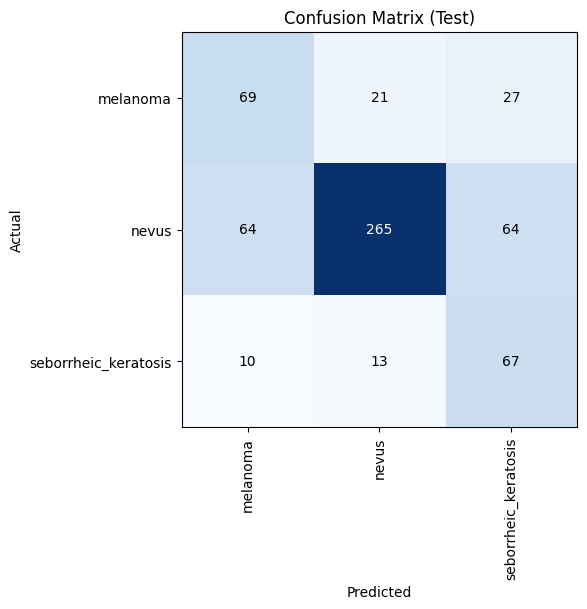

✅ Global Accuracy: 66.83%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.7911
   • Recall:  0.5897


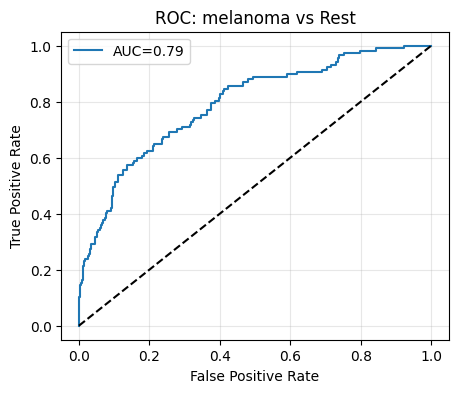

In [ ]:
show_results(dls1, learn1, 'Test', melanoma_class='melanoma')

#### **Conclusion**

Melanoma and seborrheic keratosis classes turn out to be very difficult for the network to predict, since imbalance between classes is significant.

Furthermore, the usage of regularization techniques such as data augmentation or class weighting lead to noisy convergence, which is expected. When treating imbalanced classes, misclassifying the minority classes impacts our metrics intensely.

Nevertheless, a great accuracy and F1-Score percentage is achieved. Most importantly, having a high F1-Score percentage shows that the model is balanced and ensures it is not biased toward the majority class.

#### **Saving the model**




In [ ]:
drive.mount('/content/drive', force_remount=True)

# Use dill as the pickle module to avoid 'cannot pickle code objects' error
learn1.export('/content/drive/My Drive/Colab Notebooks/VC/ProyectoFinal/EfficientNet_TL_DEF.pkl', pickle_module=dill)

print("Model saved successfully.")

Mounted at /content/drive
Model saved successfully.


### **Inception-ResNet-v2**

This model consists of the combination of two main concepts:

- Residual Learning and shortcut connections.
- Inception architecture.

Let's define both of those concepts:

#### **Residual Learning and Shortcut Connections**

Deep CNN networks have led to great breakthroughs for image classification due to their capacity to integrate features of all levels. These features can be enriched by the increase of depth, which refers to adding more layers to our network.

But as we stated in the previous model (EfficientNet Network Family), the problem of the vanishing/exploding gradients arises whenever we consider increasing network's depth. Mainly because whenever deep networks are able to start converging, accuracy saturates and degrades rapidly.

In order to create deeper networks avoiding this main problem is by construction. Therefore, a **deep residual learning framework** is proposed. It consists of letting blocks of stacked layers fit a residual mapping, that is: Instead of them fitting a mapping $\mathcal{H}(x)$, they will fit $\mathcal{F}(x) = \mathcal{H}(x) - x$. This is done as such because it is easier for a network to learn how to push the residual to zero ($\mathcal{F}(x) \rightarrow 0$) than to fit an identity mapping by stacking layers. Eventually, the original mapping is recast to $\mathcal{F}(x) + x$ (where $x$ denotes the input).

**How do we create this?** The formulation of $\mathcal{F}(x) + x$ can be done through feedforward neural networks with **shortcut connections**. Shortcut connections refers to skipping certain layers, going from the pipeline input up to the output. ResNet uses identity shortcut connections, whose output is added to the stacked layers' output.

The residual representation of problems has been proved to converge faster than traditional standpoints since a good reformulation of problems can simplify the optimization.

Now, the technique is to adopt residual learning to every few stacked layers by defining building blocks defined as: $$y = \mathcal{F}(x, {W_i}) + x$$

The dimensions of $x$ and $F$ must be equal. Although if this is not the case,  a linear projection $W_s$ (normally, a $1$x$1$ convolutional layer) will be performed by the shortcut connections to match the dimensions:

$$y = \mathcal{F}(x, {W_i}) + W_sx$$

#### **Inception architecture**

Inception is a network architecture for computer vision that introduces a new level of organization in the form of the "Inception Module" combined with larger network depth.

Inspired by neuroscience models, the strategy of using different sizes to handle multiple scales alongside the repetition of inception layers ($1$x$1$ convolutional layers) are used in this model.

The usage of $1$x$1$ convolutional layers is important due to the reason that they allow to reduce dimensionality. This is crucial to not just increase depth in our network but to increase width without significant performance penalty. Therefore, it helps us scale network's width.

Furthermore, R-CNN method is frequently used for object detection. This method decomposes the detection problem into utilizing low-level cues to generate object location proposals and using CNN classifiers. In this model, a similar pipeline is followed, but with the addition of having explored enhacements in both stages such as multi-box predictions and having ensembled approaches for better categorization of bounding box proposals.

In order to deal with the computational cost increase and the proneness to overfitting while increasing network's depth and width, sparsity should be introduced via the substitution of fully connected layers by sparse ones, even inside the convolutions. Nonetheless, Inception is an network that tries to approximate this type of networks through the usage of dense building blocks.

Since sparsity in network can become a problem, the idea was to find an optimal local construction and repeat it spatially. **Inception modules** are stacked on top of each other, and each one of those have the following structure:

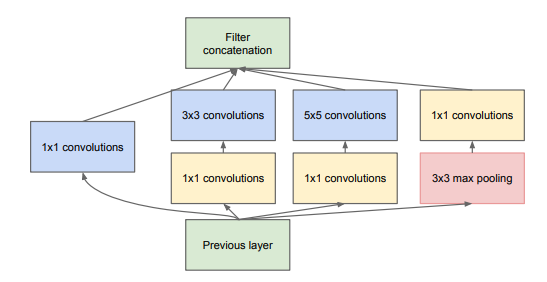

We can see they consist of convolutional layers that uses filter with sizes restricted to $1$x$1$, $3$x$3$ and $5$x$5$ in order to avoid patch-alignment issues and to keep an adequate number of parameters.

Therefore, Inception architecture consists of a number of the modules we just saw stacked on top of each other, with occasional max-pooling layers with stride $2$ to halve the resolution of the grid.

Another key innovation in this family of models was the replacement of Fully Connected layers with Global Average Pooling at the end of the network, which significantly reduces the total number of parameters and the risk of overfitting.

The first version of Inception architectures (Inception-v1) is GoogLeNet. This version's full structure is:

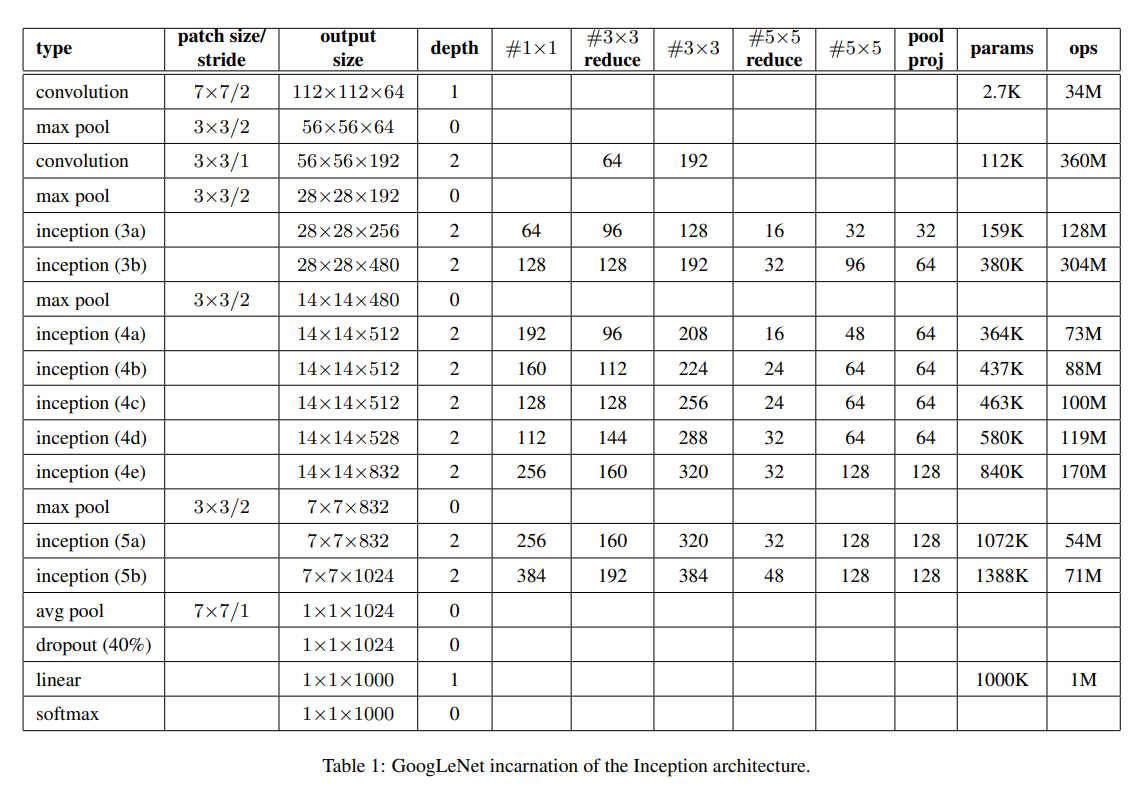

GoogLeNet (Inception-v1) represents the initial point or base of this type of architecture. The transition from Inception-v1 to versions v2 and v3 was driven by the goal of reducing computational complexity while avoiding representational bottlenecks:

Since $5$x$5$ convolutional layers suppose a great computational cost, it was introduced the substitution of these with two $3$x$3$ convolutional layers since they both would have the same **receptive field** as a $5$x$5$ layer (but reducing costs). This is what we call "Factorization into smaller convolutions".

Regarding resolution reduction, a new change involved using blocks where dimensionality-reducing convolutions and pooling layers where executed in parallel and then their outputs were concatenated. Doing so, we can increase number of filters while reducing resolution smoothly.

Lastly, the concept of "Factorization into Asymmetric Convolutions": This concepts basically focus on the idea that we can perform, for instance, $3$x$3$ convolutions executing a $1$x$3$ and a $3$x$1$ convolutional layers. **Why do we even consider this?** Because this allows expanding network's depth while reducing computational costs and maintaining training times.

These three are the main adjustments introduced in the next 2 evolutions of Inception architectures (Inception-v2 and Inception-v3).

#### **Inception-ResNet-v2**

ResNet networks are easily trainable and depth-scalable, while Inception architectures are very precise but complex. **What if we combine the two in order to obtain a new model?** Szegedy, C., Ioffe, S., Vanhoucke, V., & Alemi, A. A. formulated this question and created a new model called **Inception-ResNet-v1 and Inception-ResNet-v2**.

These models combine the precision from Inception architectures while leveraging ResNet great convergence and scalability. Both models share a new architectural philosophy through a new block: **Inception-ResNet Block**

This block takes as a base the Inception module from **Inception Architectures**. Instead of concatenating the outputs from the parallel branches (which incorporate the previously mentioned factorized $3 \times 3$ and asymmetric convolutions to cover different receptive fields), all of those outputs are combined using a $1$x$1$ convolutional layer. This final $1$x$1$ convolutional layer is used to scale the number of channels, ensuring that the output of the parallel branches matches the original input dimensions before they are summed together, following the idea of **Residual Learning** from ResNet. It is important to mention that the residual output is scaled (**Residual Scaling**, typically by a factor of 0.1) in order to avoid numerical instability and prevent the network from 'dying' during training. Therefore, we can clearly see how both concepts (from ResNet and Inception architectures) are combined into a new single block.

There are three different variants of this block: **Inception-ResNet-A Block**,
**Inception-ResNet-B Block** and **Inception-ResNet-C Block** which are used for different purposes. Each of these blocks include the concepts introduced with Inception-v2 and Inception-v3.

Although **Inception-ResNet-v1 and Inception-ResNet-v2** are similar since they share the architectural philosophy, the main difference between them is in the initial layers that process the input image before it enters the Inception-ResNet Blocks, which is called **Stem**.

Inception-ResNet-v2 uses the stem from the last version of the Inception family architectures: Inception-v4. It consists in multiple convolutional layers and concatenation of their results in order to perform better feature extraction. Furthermore, Inception-ResNet-v2 also uses new blocks present in Inception-v4 (combined with the application of Residual Learning). Inception-v4 introduces a highly uniform structure by defining three distinct Inception modules (Inception-A, Inception-B, and Inception-C) and specialized Reduction Blocks. These Reduction Blocks are critical as they perform spatial dimensionality reduction by running pooling and stride-convolutions in parallel, effectively preventing 'representational bottlenecks' while increasing the filter bank depth.

The stem used in Inception-ResNet-v1 is far simpler, and therefore, we obtain less accuracy with it. That is why we opt to use Inception-ResNet-v2.

In conclusion, we obtain an efficient and fast-convergent model that is very well suited for computer vision tasks: **Inception-ResNet-v2**.

#### **Main references**

- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.

- Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., Erhan, D., Vanhoucke, V., & Rabinovich, A. (2015). Going deeper with convolutions. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 1-9.

- Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2818-2826.

- Szegedy, C., Ioffe, S., Vanhoucke, V., & Alemi, A. A. (2017). Inception-v4, inception-resnet and the impact of residual connections on learning. Proceedings of the AAAI Conference on Artificial Intelligence, 31(1), 4278-4284.
---
<br>

#### **Why is this model being considered for this problem?**

As it has been stated, Inception-ResNet-v2 has been proved to be suited for computer vision tasks, which is exactly what we are doing since we will be processing melanoma images.

Furthermore, the network's parallel architecture allow us to process images **at the same time** using different kernel sizes. This allows the network to detect large and fine dermatological patterns in parallel (at the same time).

Last but not least, the concept of residual learning leads to a more secure and faster convergence since it helps with optimization and avoids the vanishing gradient problem. In fact, residual learning makes the model assume that the actual block or layers will not worsen in any aspect what the previous layers or blocks learned. That is, if the new layers or block do not learn anything interesting, the addition through the shortcut of the original input allow us not to lose the information from previous layers.

#### **Creation of the Datablock for second model**

In [ ]:
# List files and directories in the current working directory
!ls -lha
# List files and directories within the downloaded dataset path
!ls /content/dataset/skin-lesions/

total 32K
drwxr-xr-x 1 root root 4.0K Jan  4 11:20 .
drwxr-xr-x 1 root root 4.0K Jan  4 09:19 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Jan  4 09:41 dataset
drwxr-xr-x 5 root root 4.0K Jan  4 11:26 dataset_recortado
drwx------ 5 root root 4.0K Jan  4 10:47 drive
drwxr-xr-x 2 root root 4.0K Jan  4 12:47 models
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
test  train  valid


In [ ]:
# Define the base path for the dataset
path = Path("/content/dataset/skin-lesions")
# Define paths for training, validation, and test sets
train_path = path/'train'
valid_path = path/'valid'
test_path  = path/'test'

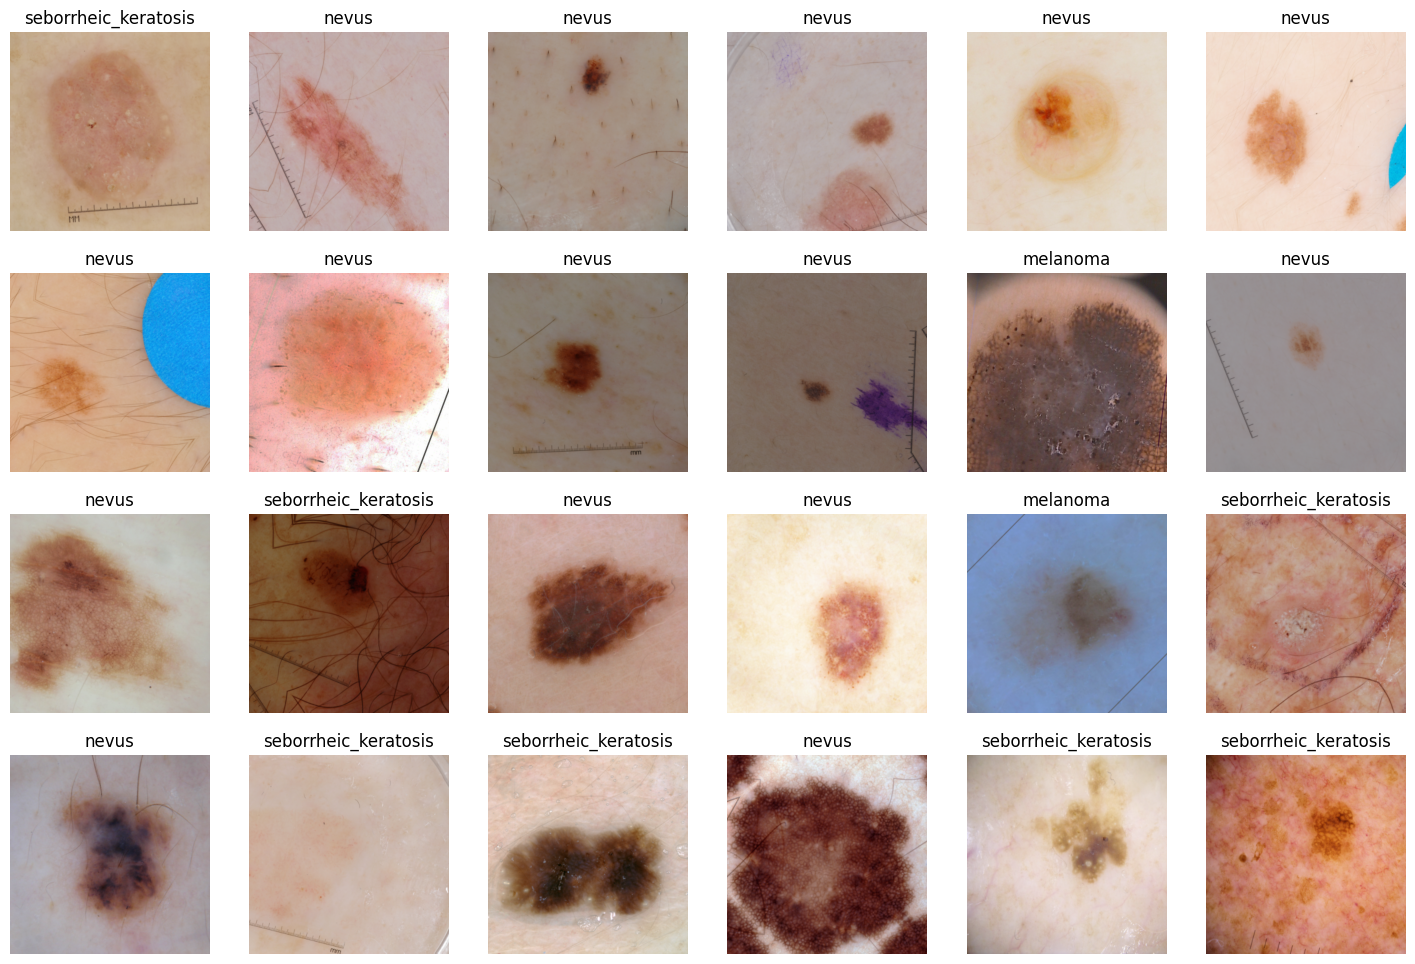

In [ ]:
# Create a DataBlock for image classification
dtblk2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),         # Define input (Image) and target (Category) blocks
    get_items=get_image_files,                  # Function to get all image files
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), # Split data based on 'train' and 'valid' folders
    get_y=parent_label,                         # Function to get labels from parent folder names
    item_tfms=Resize(460),   # Apply resizing to 460x460 for individual items
    batch_tfms=[                                # Apply batch transformations (augmentation and normalization)
        *aug_transforms(size=384,           # Resizing to 384x384 (Inception-Resnet-v2 used this size for training)
                        mult=1.0,
                        do_flip=True,       # Allows to flip the images
                        flip_vert=True,     # Allows to flip the images
                        max_rotate=90.0,    # Up to 90 degrees rotation
                        max_zoom=0.7,       # Max Zoom value
                        max_lighting=0.4,   # Max Lighting transformations value
                        max_warp=0.0        # No warping
                        ),
        Normalize.from_stats(*imagenet_stats) # Normalize using ImageNet statistics
    ]
)

# Create DataLoaders from the DataBlock and the specified path, with a batch size of 64
dls2=dtblk2.dataloaders(path,bs=64)

# Display a batch of images with their labels
dls2.show_batch(max_n=24)

#### **Pipeline**

In order to adapt **Inception_ResNet_v2**, we should define a custom head. Leveraging fastai functionalities, the usage of **vision_learner** introduces an automatic custom head that adapts the network to our new classification problem. (Number of classes: $3$).

Instead of using the function **fine_tune**, manually freezing and unfreezing will be performed while training using **fit_one_cycle**. We will train only the head during 5 epochs and the whole network during 20.

Firstly, using what we studied in the previous case, CrossEntropyLossFlat() was discarded. Class weights and LabelSmoothingCrossEntropy loss function was directly used. However, this model is way larger than the previous one, therefore, further and stricter regularization techniques were applied in order to avoid Overfitting and achieve greater results.

Starting with stronger data augmentation and weight decay was not enough for the model since it resulted in the model getting stuck at mediocre metric values.

Since this model (Inception-ResNet-v2) relies highly on visual information and details, and classes are very imbalanced, MixUp() as a callback was considered. MixUp is a powerful data augmentation technique that consists of creating synthetic training examples by taking two random images and blending them together. This way, we avoid training the network on "pure" individual images. This technique allowed the model to take more into consideration minority classes, since they were being almost utterly ignored.

Now, in this case, coping with noise was a difficult task. As mentioned, this large model extremely relies on image details. Some of the images from the dataset are clear, but some of those have different deceiving information for the model, such as hairs, markers-made arrows or points... Furthermore, the images were not of the same size, therefore, just by applying resizing a great amount of the skin lesions' information was lost. Having said this, an attempt to apply a skin lession detector (to center the images in the lesion and then crop them around it) was made. Different approximations were taken with Gemini generative AI model's help, such as an approximation using Otsu's algorithm... Despite our efforts, it was nearly impossible to perform this cropping action nicely: frequently, some images only showed hair, meaning that after cropping, we were left with nothing but a photo of hair, thereby losing the lesion's information entirely. In consequence, this approach was abandoned in favor of a more careful and robust regularization strategy.

After some tuning and trying different optimizers, the conclusion was that the higher results that can be achieved are obtained using the following hyperparameters:

In [ ]:
# Calculate weights for each class:
from collections import Counter

total = sum(values)
n_classes = len(values)

# Formula: weight = Total / (n_classes * n_examples_per_class)
weights = [total / (n_classes * c) for c in values]
weights_tensor = torch.tensor(weights, dtype=torch.float32).cuda()

#  Create a fastai Vision Learner object
learn2 = vision_learner(dls2,
                        'inception_resnet_v2',
                        loss_func=LabelSmoothingCrossEntropy(weight=weights_tensor), # Cambio de Loss
                        metrics=[accuracy, F1Score(average='macro')],
                        opt_func=Adam,
                        pretrained=True,
                        ps=0.4,
                        cbs=MixUp(0.2)).to_fp16()

# Display a summary of the model architecture and trainable parameters
learn2.summary()

Sequential (Input shape: 64 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 191 x 191 
Conv2d                                    864        False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 189 x 189 
Conv2d                                    9216       False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 189 x 189 
Conv2d                                    18432      False     
Identity                                                       
ReLU                                                           
___________________________________

#### **Training**

In [ ]:
# Freeze the model
learn2.freeze()
learn2.summary()

Sequential (Input shape: 64 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 191 x 191 
Conv2d                                    864        False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 189 x 189 
Conv2d                                    9216       False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 189 x 189 
Conv2d                                    18432      False     
Identity                                                       
ReLU                                                           
___________________________________

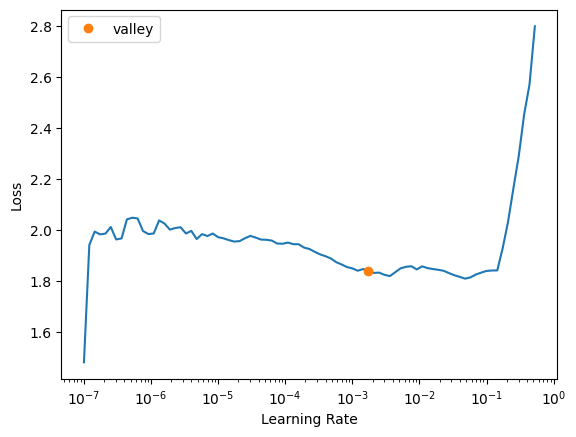

In [ ]:
# Search for valley value to use as learning rate:
lr=learn2.lr_find()

In [ ]:
# Record the start time of training
start=time.time()
# Fine-tuning model
learn2.fit_one_cycle(5, lr_max=lr[0])
# Record the end time of training
end = time.time()

head_time=end-start

In [ ]:
# Unfreeze the model
learn2.unfreeze()
learn2.summary()

Sequential (Input shape: 64 x 3 x 384 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 191 x 191 
Conv2d                                    864        True      
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 189 x 189 
Conv2d                                    9216       True      
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 189 x 189 
Conv2d                                    18432      True      
Identity                                                       
ReLU                                                           
___________________________________

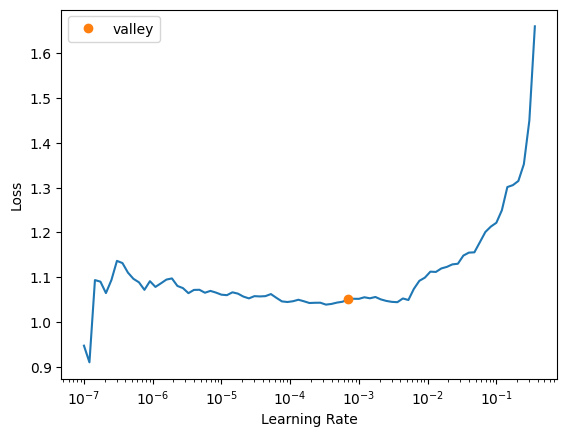

In [ ]:
# Search for valley value to use as learning rate:
lr=learn2.lr_find()

No improvement since epoch 14: early stopping
Total training time: 1866.61 seconds


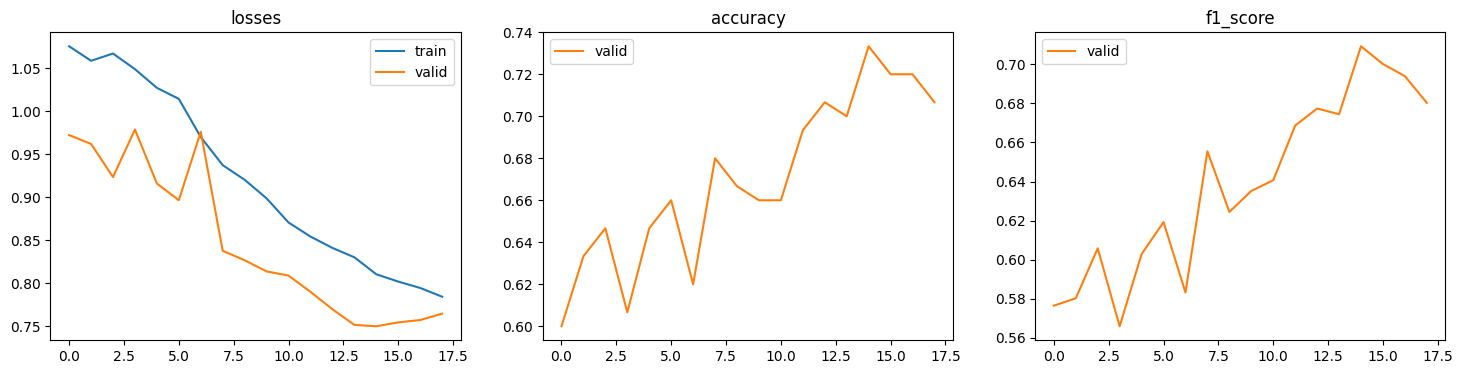

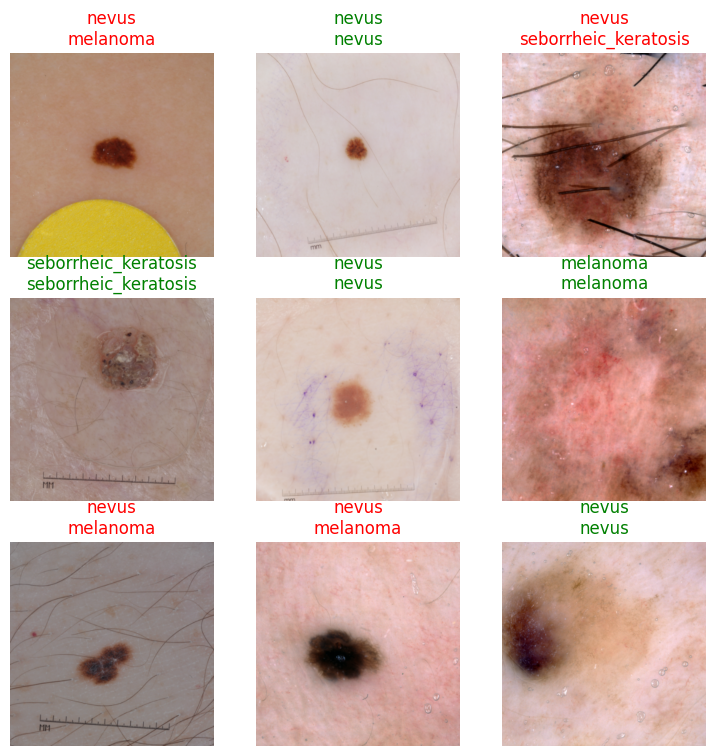

In [ ]:
# Record the start time of training
start=time.time()
# Fine-tuning model
learn2.fit_one_cycle(20, lr_max=(1e-5, 1e-3), wd=0.2, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
# Record the end time of training
end = time.time()

whole_network_time=end-start

# Print the total training time
print(f"Total training time: {whole_network_time + head_time:.2f} seconds")
# Plot the training and validation metrics over epochs
learn2.recorder.plot_metrics()
# Show results (implicitly calls show_results with default 'Validation' mode if not specified, or a quick visual check)
learn2.show_results()


==================== Evaluating: Train ====================


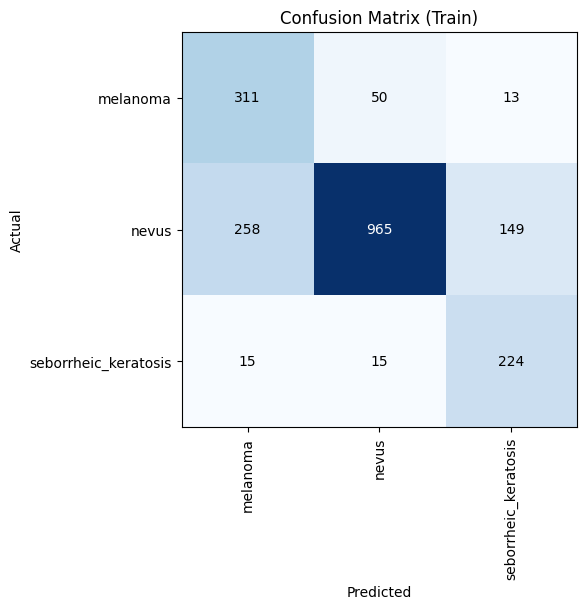

✅ Global Accuracy: 74.45%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8959
   • Recall:  0.7941


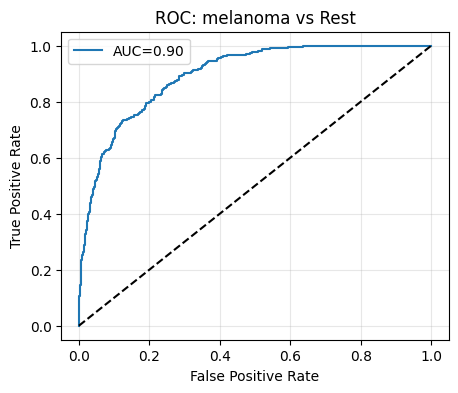

In [ ]:
show_results(dls2, learn2, 'Train', melanoma_class='melanoma')

#### **Validation**


==================== Evaluating: Validation ====================


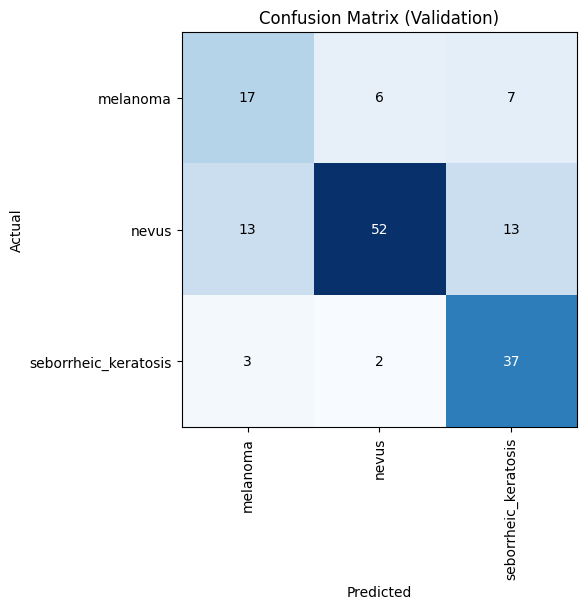

✅ Global Accuracy: 70.67%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8047
   • Recall:  0.5667


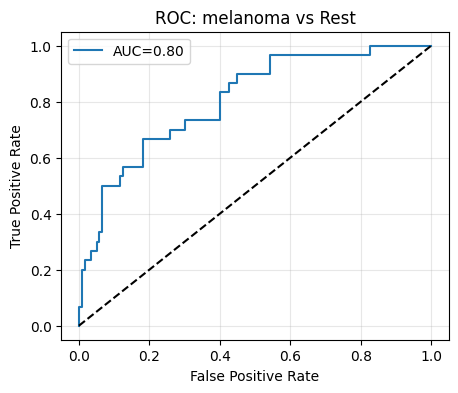

In [ ]:
show_results(dls2, learn2, 'Validation', melanoma_class='melanoma')

#### **Test**


==================== Evaluating: Test ====================


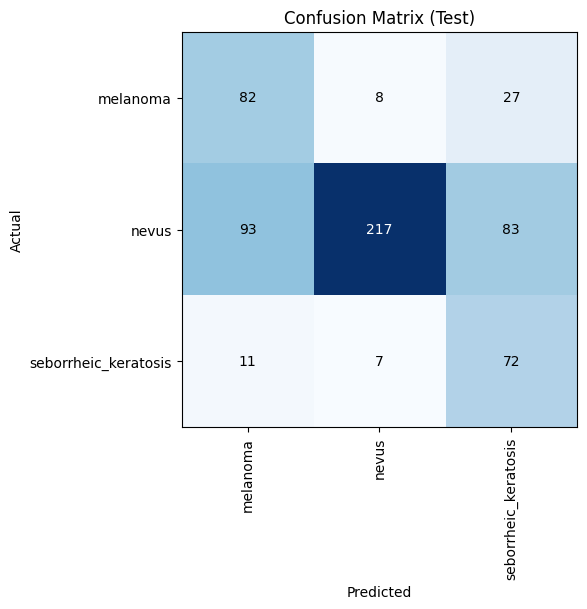

✅ Global Accuracy: 61.83%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.7975
   • Recall:  0.7009


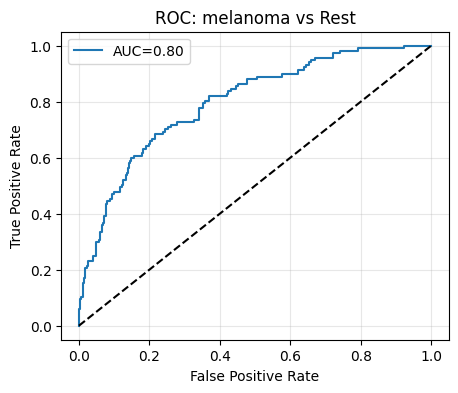

In [ ]:
show_results(dls2, learn2, 'Test', melanoma_class='melanoma')

#### **Conclusion**

Once again, seborrheic keratosis and melanoma classes are more difficult to predict. While the high-capacity architecture of Inception-ResNet-v2 was promising as an excellent solution, the noise present in some photos proved to be its worst enemy.

The main reason for the noisy convergence is due to all the noise present and visual interference. As stated, this model highly depends on fine-grained visual information through its extensive filter layers. Therefore, artifacts like skin hair or markers significantly disrupt the learning process.

Nevertheless, MixUp and Label Smoothing combined allowed the model to look past these artifacts, focusing on robust morphological patterns rather than superficial noise.

In conclusion, an impeccable balance was achieved by successfully avoiding a bias toward the majority class.

#### **Saving the model**

In [ ]:
drive.mount('/content/drive', force_remount=True)

# Use dill as the pickle module to avoid 'cannot pickle code objects' error
learn2.export('/content/drive/My Drive/Colab Notebooks/VC/ProyectoFinal/Inception_ResNet_v2_TL.pkl', pickle_module=dill)

print("Model saved successfully.")

Mounted at /content/drive
Model saved successfully.
